## Netflix_Content_Strategy_Analysis

In [199]:
#importing  necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample
from joblib import Parallel, delayed

# Loading the dataset
file_path = 'netflix_content_2023.csv'
data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset to understand its structure
data.head()

,Title,Available Globally?,Release Date,Hours Viewed,Language Indicator,Content Type
0,The Night Agent: Season 1,Yes,2023-03-23,"81,21,00,000",English,Show
1,Ginny & Georgia: Season 2,Yes,2023-01-05,"66,51,00,000",English,Show
2,The Glory: Season 1 // 더 글로리: 시즌 1,Yes,2022-12-30,"62,28,00,000",Korean,Show
3,Wednesday: Season 1,Yes,2022-11-23,"50,77,00,000",English,Show
4,Queen Charlotte: A Bridgerton Story,Yes,2023-05-04,"50,30,00,000",English,Movie


In [204]:
# Cleaning and transforming the dataset

# Converting 'Hours Viewed' to numeric by removing commas and converting to integer
data['Hours Viewed'] = data['Hours Viewed'].str.replace(',', '').astype(int)

# Converting 'Available Globally?' to binary encoding
data['Available Globally?'] = data['Available Globally?'].map({'Yes': 1, 'No': 0})

# Filling the missing 'Release Date' with a placeholder and extracting the year and month
data['Release Date'] = pd.to_datetime(data['Release Date'], errors='coerce')
data['Release Year'] = data['Release Date'].dt.year.fillna(0).astype(int)
data['Release Month'] = data['Release Date'].dt.month

# Converting 'Language Indicator' and 'Content Type' into dummy/encoded variables
data = pd.get_dummies(data, columns=['Language Indicator', 'Content Type'], drop_first=True)

# Verifying the cleaned dataset
data_cleaned = data[['Hours Viewed', 'Available Globally?', 'Release Year'] + 
                    [col for col in data.columns if 'Language Indicator_' in col or 'Content Type_' in col]]

# printing few rows of cleaned data.
data_cleaned.head(), data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24812 entries, 0 to 24811
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Hours Viewed                    24812 non-null  int32
 1   Available Globally?             24812 non-null  int64
 2   Release Year                    24812 non-null  int32
 3   Language Indicator_Hindi        24812 non-null  bool 
 4   Language Indicator_Japanese     24812 non-null  bool 
 5   Language Indicator_Korean       24812 non-null  bool 
 6   Language Indicator_Non-English  24812 non-null  bool 
 7   Language Indicator_Russian      24812 non-null  bool 
 8   Content Type_Show               24812 non-null  bool 
dtypes: bool(6), int32(2), int64(1)
memory usage: 533.2 KB


(   Hours Viewed  Available Globally?  Release Year  Language Indicator_Hindi  \
 0     812100000                    1          2023                     False   
 1     665100000                    1          2023                     False   
 2     622800000                    1          2022                     False   
 3     507700000                    1          2022                     False   
 4     503000000                    1          2023                     False   
 
    Language Indicator_Japanese  Language Indicator_Korean  \
 0                        False                      False   
 1                        False                      False   
 2                        False                       True   
 3                        False                      False   
 4                        False                      False   
 
    Language Indicator_Non-English  Language Indicator_Russian  \
 0                           False                       False   
 1    

Summary Statistics:
       Hours Viewed  Available Globally?  Release Year
count  2.481200e+04         24812.000000  24812.000000
mean   6.384084e+06             0.308319    664.776358
std    2.067086e+07             0.461808    949.150221
min    1.000000e+05             0.000000      0.000000
25%    3.000000e+05             0.000000      0.000000
50%    1.100000e+06             0.000000      0.000000
75%    4.700000e+06             1.000000   2018.000000
max    8.121000e+08             1.000000   2023.000000

Skewness:
Hours Viewed                      13.304757
Available Globally?                0.830201
Release Year                       0.727387
Language Indicator_Hindi           7.960227
Language Indicator_Japanese        2.811564
Language Indicator_Korean          3.571217
Language Indicator_Non-English     2.186591
Language Indicator_Russian        25.165120
Content Type_Show                  0.276356
dtype: float64

Kurtosis:
Hours Viewed                      308.611788
Availab

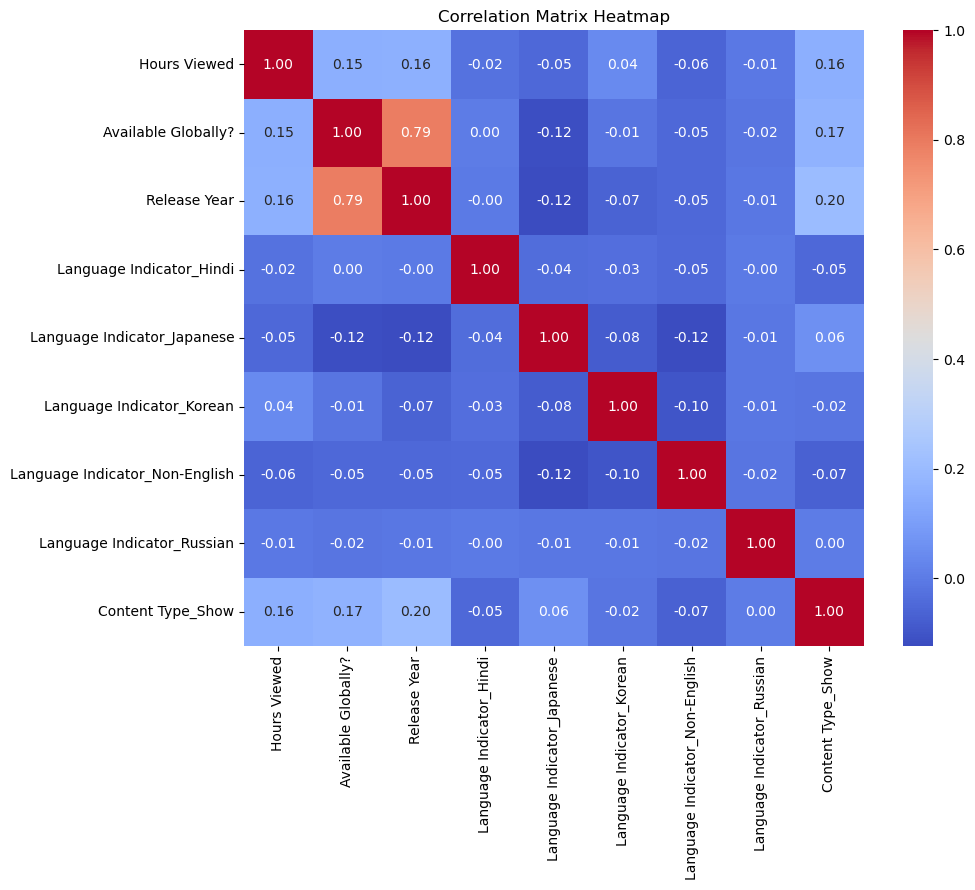

In [184]:
# Data Summary Statistics

# descriptive statistics for the cleaned dataset
summary_statistics = data_cleaned.describe()
print("Summary Statistics:")
print(summary_statistics)

# Skewness Calculation
# kewness for each numerical column
skewness = data_cleaned.skew()
print("\nSkewness:")
print(skewness)

# Kurtosis Calculation
# kurtosis for each numerical column
kurtosis = data_cleaned.kurtosis()
print("\nKurtosis:")
print(kurtosis)

# Correlation Matrix Calculation
# the correlation matrix for numerical columns
correlation_matrix = data_cleaned.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Correlation Matrix Visualization
# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

## Relational Graph
### Line plot

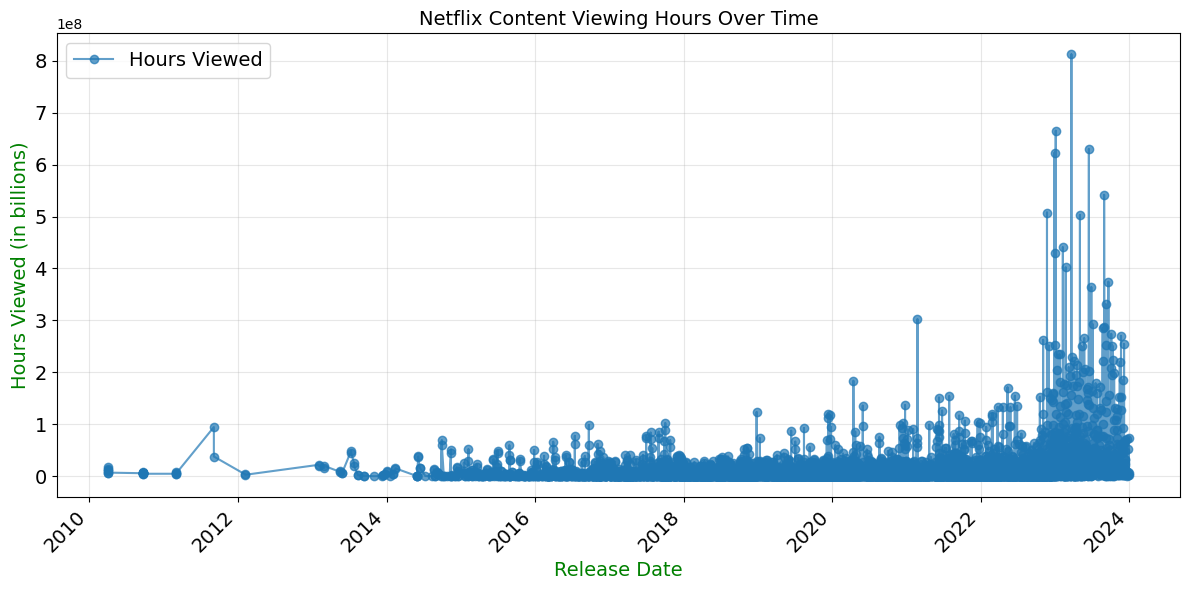

In [185]:
def plot_hours_over_time(data):
    """
    Filtering the data to remove rows with missing values in 'Release Date' 
    or 'Hours Viewed', sorting the data by 'Release Date', and then plotting 
    a line chart showing the trend of 'Hours Viewed' over time (by 
    'Release Date').

    Parameters:
    - data: Pandas DataFrame containing 'Release Date' and 'Hours Viewed' 
      columns.
    """
    # Filtering for rows with valid data for plotting
    cleaned_data = data.dropna(subset=['Release Date', 'Hours Viewed'])

    # Sorting data by release date for better visualization
    cleaned_data = data.sort_values('Release Date')

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(
        cleaned_data['Release Date'], 
        cleaned_data['Hours Viewed'], 
        linestyle='-', 
        marker='o', 
        alpha=0.7, 
        label='Hours Viewed'
    )
    
    plt.title('Netflix Content Viewing Hours Over Time', fontsize=14)
    plt.xlabel('Release Date', fontsize=14, color='green')
    plt.ylabel('Hours Viewed (in billions)', fontsize=14, color='green')
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig('line_plot.png')
    plt.show()

plot_hours_over_time(data)

## Categorical Graph
### Pie chart

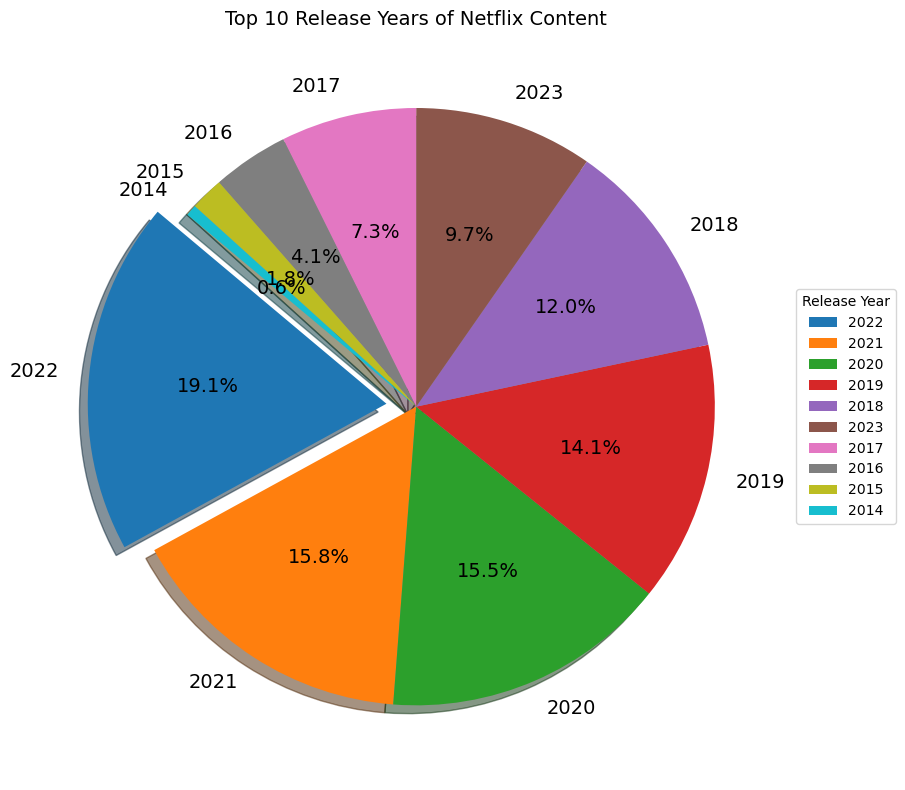

In [186]:
def plot_pie_chart_release_year(data):
    """
    Plotting a pie chart showing the proportion of Netflix content by release 
    year.

    Parameters:
    - data: Pandas DataFrame containing the 'Release Year' column.
    """
    data_filtered = data[data['Release Year'] != 0]

    # Summarize the data
    release_year_distribution = data_filtered['Release Year'].value_counts().nlargest(10)

    # Plot the pie chart
    plt.figure(figsize=(10, 8))
    explode = [0.1 if i == 0 else 0 for i in range(len(release_year_distribution))]
    plt.pie(
        release_year_distribution.values,
        labels=release_year_distribution.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("tab10", len(release_year_distribution)),
        explode=explode,
        shadow=True,
        textprops={'fontsize': 14}
    )
    
    plt.title('Top 10 Release Years of Netflix Content', fontsize=14)
    plt.legend(
        release_year_distribution.index, 
        title="Release Year", 
        loc="center left", 
        bbox_to_anchor=(1, 0.5)
    )
    plt.tight_layout()
    plt.savefig('release_year_pie_chart.png')  # Updated filename for clarity
    plt.show()

plot_pie_chart_release_year(data)

## Statistical Graph
### Heat Map

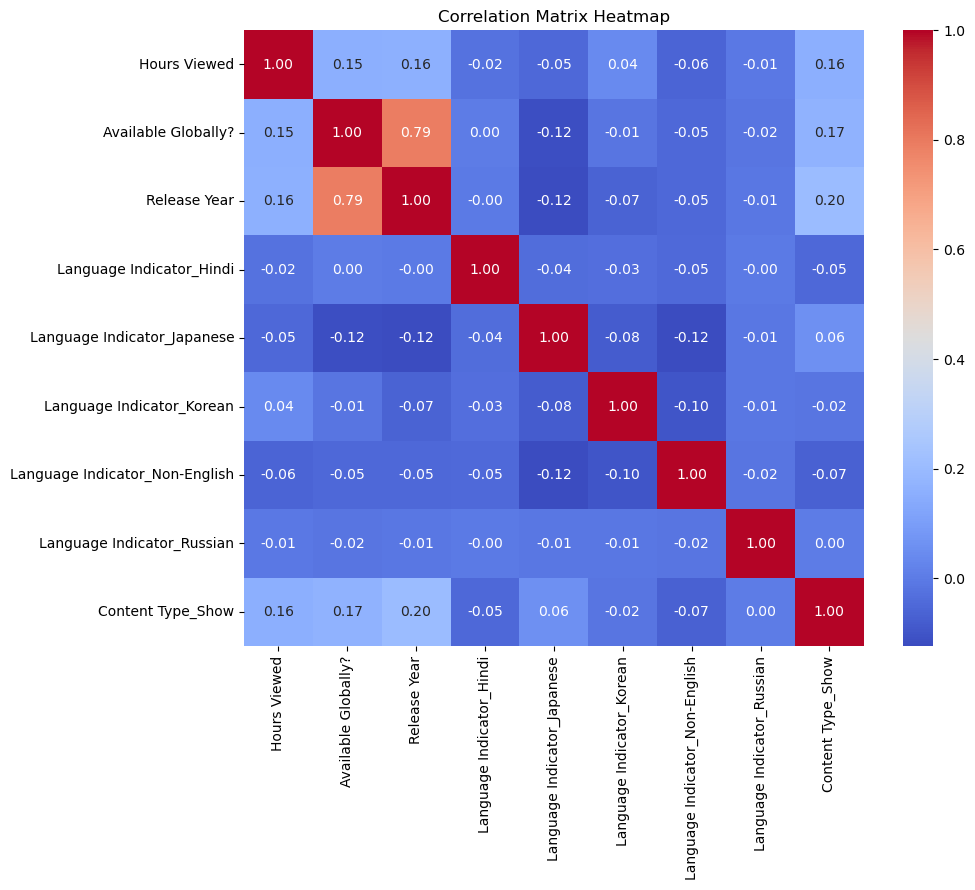

In [187]:
def plot_correlation_heatmap(correlation_matrix, figsize=(10, 8), cmap="coolwarm", title="Correlation Matrix Heatmap"):
    """
    Plotting a heatmap for a correlation matrix.

    Parameters:
    -----------
    corr_matrix : The correlation matrix to visualize.
        
    figsize :  The size of the figure in inches. Default is (10, 8).
       
    cmap : The colormap to use for the heatmap. Default is 'coolwarm'.
        
    title : The title for the heatmap. Default is 'Correlation Matrix Heatmap'.
    
    Returns:
    --------
    None
        Displays the heatmap using matplotlib.
    """
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f")
    plt.title(title)
    plt.savefig('Heatmap')
    plt.show()

correlation_matrix = data_cleaned.corr()
plot_correlation_heatmap(correlation_matrix)

## Clustering and fitting

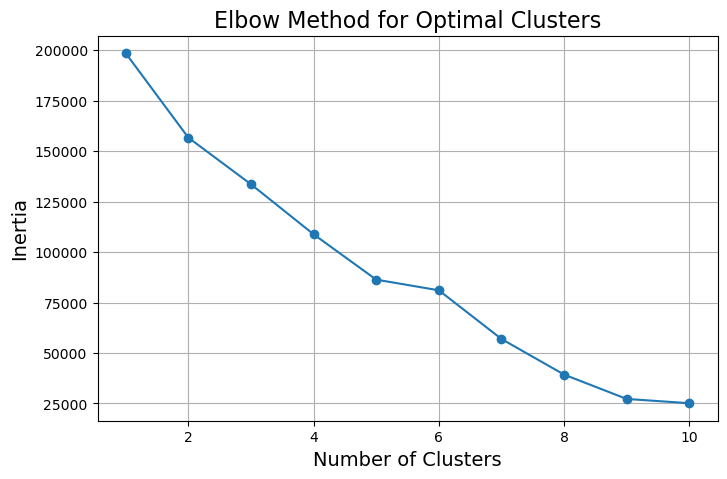

In [190]:
# Selecting features for clustering
clustering_features = data_cleaned[['Hours Viewed', 'Release Year', 'Available Globally?'] + 
                                    [col for col in data_cleaned.columns if 'Language Indicator_' in col]]

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Determining the optimal number of clusters
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.grid()
plt.savefig('elbow')
plt.show()

Cluster Centers (Back-scaled):
    Hours Viewed  Release Year  Available Globally?  Language Indicator_Hindi  \
0  9.720860e+06    426.629583             0.281922             -1.214306e-17   
1  3.753786e+06      9.377684             0.011643              1.695942e-02   
2  1.045744e+07   1880.223116             0.843375              1.464234e-02   
3  2.938462e+06    362.589744             0.102564              1.734723e-18   

   Language Indicator_Japanese  Language Indicator_Korean  \
0                -1.110223e-16               1.000000e+00   
1                 1.361464e-01              -1.929013e-15   
2                 3.288526e-02              -1.568190e-15   
3                -1.387779e-17               1.387779e-17   

   Language Indicator_Non-English  Language Indicator_Russian  
0                    1.387779e-16               -1.084202e-18  
1                    1.592974e-01               -1.431147e-17  
2                    1.062170e-01                5.854692e-18  
3    

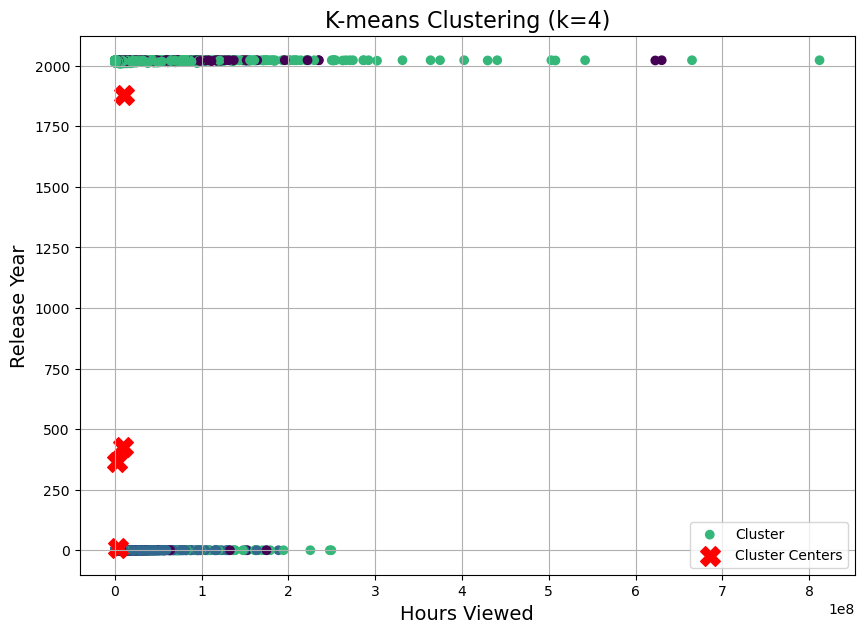

In [191]:
# From the elbow method, choosing the optimal number of clusters
optimal_clusters = 4 

# Performing K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_cleaned.loc[:,'Cluster'] = kmeans.fit_predict(scaled_features)

# Analyzing cluster centers and transform them back to the original scale
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                               columns=clustering_features.columns)

# Sampling Data Points from Each Cluster (For analysis)
cluster_samples = {}
for cluster in range(optimal_clusters):
    cluster_samples[cluster] = data_cleaned[data_cleaned['Cluster'] == cluster].head(3)

# Output of cluster centers and samples
print("Cluster Centers (Back-scaled):\n", cluster_centers)
print("\nSample Data Points from Each Cluster:")
for cluster, samples in cluster_samples.items():
    print(f"\nCluster {cluster} Sample Data:")
    print(samples)

# Visualizing the clusters
plt.figure(figsize=(10, 7))
plt.scatter(data_cleaned['Hours Viewed'], data_cleaned['Release Year'], c=data_cleaned['Cluster'], cmap='viridis', label='Cluster')
plt.scatter(cluster_centers['Hours Viewed'], cluster_centers['Release Year'], s=200, c='red', marker='X', label='Cluster Centers')
plt.title(f'K-means Clustering (k={optimal_clusters})', fontsize=16)
plt.xlabel('Hours Viewed', fontsize=14)
plt.ylabel('Release Year', fontsize=14)
plt.legend()
plt.grid()
plt.savefig('cluster_centers')
plt.show()

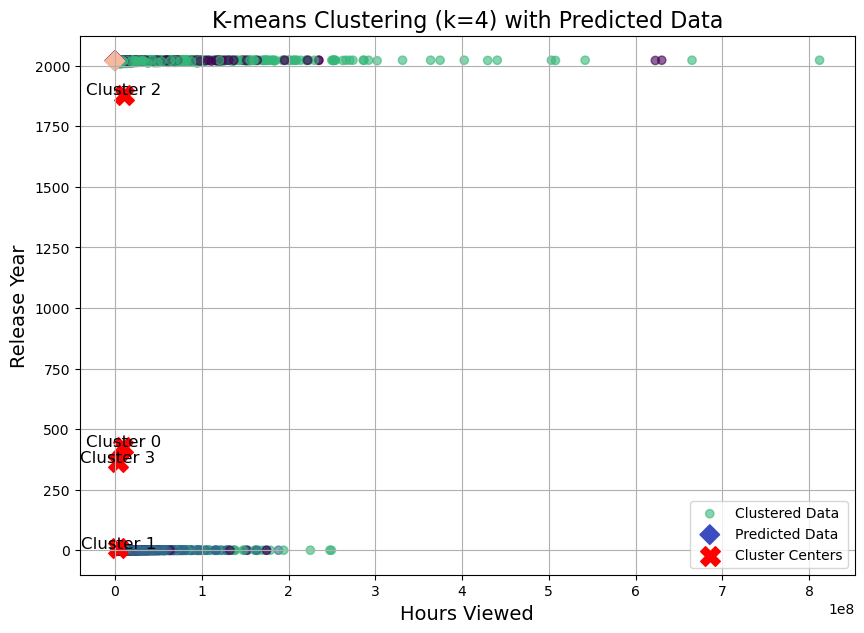

In [192]:
# Predicting new data points and assigning them to clusters
# Retrieving the columns the model was trained on
trained_features = scaler.feature_names_in_

# New data with adjusted columns
new_data = pd.DataFrame({
    'Hours Viewed': [120, 350, 600],
    'Release Year': [2022, 2021, 2020],
    'Available Globally?': [1, 0, 1],
    'Language Indicator_Hindi': [0, 0, 0],
    'Language Indicator_Japanese': [0, 0, 0],
    'Language Indicator_Korean': [1, 0, 0],
    'Language Indicator_Non-English': [0, 0, 1],
    'Language Indicator_Russian': [0, 1, 0]
})

# Ensuring columns match the trained features (add missing columns, remove extras)
for col in trained_features:
    if col not in new_data.columns:
        new_data[col] = 0  # Add missing columns with default value (0)

# Ensuring column order matches the trained model
new_data = new_data[trained_features]  

# Standardizing the new data
scaled_new_data = scaler.transform(new_data)

# Predicting clusters for new data points
new_data['Cluster'] = kmeans.predict(scaled_new_data)

# Visualizing the clusters and the predicted points
plt.figure(figsize=(10, 7))

# Plotting the original clusters
plt.scatter(data_cleaned['Hours Viewed'], data_cleaned['Release Year'], 
            c=data_cleaned['Cluster'], cmap='viridis', label='Clustered Data', alpha=0.6)

# Plotting the predicted new data points with a different color
plt.scatter(new_data['Hours Viewed'], new_data['Release Year'], 
            c=new_data['Cluster'], cmap='coolwarm', marker='D', label='Predicted Data', s=100)

# Plotting the cluster centers
plt.scatter(cluster_centers['Hours Viewed'], cluster_centers['Release Year'], 
            s=200, c='red', marker='X', label='Cluster Centers')

# Labeling the clusters
for i in range(optimal_clusters):
    plt.text(cluster_centers['Hours Viewed'][i], cluster_centers['Release Year'][i], f'Cluster {i}',
             fontsize=12, color='black', ha='center')

plt.title(f'K-means Clustering (k={optimal_clusters}) with Predicted Data', fontsize=16)
plt.xlabel('Hours Viewed', fontsize=14)
plt.ylabel('Release Year', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## Fitting

In [193]:
# Calculating silhouette score for the clusters
silhouette_avg = silhouette_score(scaled_features, clustered_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.4f}')

Silhouette Score: 0.7355


In [195]:
# Grouping data by clusters and calculating mean values for key features
cluster_analysis = clustered_data.groupby('Cluster').mean()
cluster_analysis.head()

,Hours Viewed,Available Globally?,Release Year,Language Indicator_Hindi,Language Indicator_Japanese,Language Indicator_Korean,Language Indicator_Non-English,Language Indicator_Russian,Content Type_Show
Cluster,,,,,,,,,
0,3.315000e+06,0.089516,19.527419,0.0,0.0,1.0,0.000000,0.0,0.329032
1,4.381848e+06,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.359502
2,9.680869e+06,0.000000,2018.948244,0.0,0.0,0.0,0.000000,0.0,0.626617
3,2.938462e+06,0.102564,362.589744,0.0,0.0,0.0,0.000000,1.0,0.461538
4,7.714489e+06,1.000000,1851.351202,0.0,0.0,0.0,0.101087,0.0,0.544953


In [198]:
'''
Fitting the Model (Random Forest Regressor):
splitting the data and fitting a Random Forest model.
'''
# Setting the target as 'Hours Viewed'
target = data_cleaned['Hours Viewed']

# Preparing features with clusters
features_with_clusters = pd.DataFrame(scaled_features, columns=clustering_features.columns)
features_with_clusters['Cluster'] = clustered_data['Cluster']

# Splitting into train-test sets
X_train, X_test, y_train, y_test = train_test_split(features_with_clusters, target, test_size=0.2, random_state=42)

# Fitting a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')

Mean Squared Error: 14633360064.4771


In [203]:
'''
Bootstrapping for Confidence Intervals and Predictions:
criteria of predicting with uncertainty.
'''
# Using Decision Tree for faster bootstrapping
model_for_bootstrap = DecisionTreeRegressor(random_state=42)

# Bootstrap to estimate prediction intervals
n_bootstrap = 100  # Reduced number of bootstrap samples
predictions = []

# Function for each bootstrap iteration
def bootstrap_iteration(X_train, y_train, model, X_test):
    X_resampled, y_resampled = resample(X_train, y_train, random_state=42)
    model.fit(X_resampled, y_resampled)
    return model.predict(X_test)

# bootstrap iterations in parallel
predictions = Parallel(n_jobs=-1)(delayed(bootstrap_iteration)(X_train, y_train, model_for_bootstrap, X_test) for _ in range(n_bootstrap))

# Converting predictions to numpy array
predictions = np.array(predictions)

# Calculating the confidence intervals (e.g., 95% CI)
lower_bound = np.percentile(predictions, 2.5, axis=0)
upper_bound = np.percentile(predictions, 97.5, axis=0)

# Get the mean predictions for the point estimates
mean_predictions = np.mean(predictions, axis=0)

# Calculating error (for plotting error bars)
errors = upper_bound - lower_bound

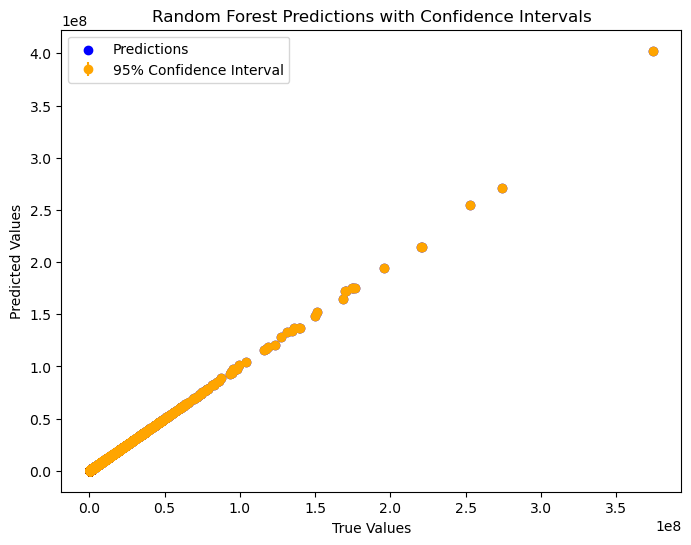

In [202]:
'''
Plotting Predictions with Error Bars:
confidence intervals and errors are calculated and visualized the predictions with error bars.
'''
# Plotting with error bars (95% CI)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, mean_predictions, label="Predictions", color='blue')
plt.errorbar(y_test, mean_predictions, yerr=errors, fmt='o', color='orange', label="95% Confidence Interval")

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Predictions with Confidence Intervals')
plt.legend()
plt.savefig('random_forest')
plt.show()